## Imports

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, roc_curve, auc, confusion_matrix, f1_score

import matplotlib.pyplot as plt

## Load data and train test split

In [44]:
df = pd.read_parquet('../data/cleaned.parquet')
df.shape

(4646773, 23)

Drop unrelevant columns

In [45]:
df = df.drop(columns=['CodeDecision', 'ZIBZIN', 'IDAvisAutorisationCheque'])

Convert date string to datetime

In [46]:
df['DateTransaction'] = pd.to_datetime(
    df['DateTransaction'],
    format="%Y-%m-%d %H:%M:%S",  # correct order
    errors='raise'
)

Split date in year, month, day

In [47]:
df['year'] = df['DateTransaction'].dt.year
df['month'] = df['DateTransaction'].dt.month
df['day'] = df['DateTransaction'].dt.day

Keep data until `2017-08-31` for train, get the rest for test

In [49]:
cutoff = pd.Timestamp("2017-08-31")
mask = df['DateTransaction'] > cutoff

# Drop DateTransaction column
df = df.drop(columns=['DateTransaction'])

train_df = df[~mask].copy()
test_df = df[mask].copy()

In [50]:
print(train_df.shape)
print(test_df.shape)

(3888468, 22)
(758305, 22)


Structure X and y

In [51]:
X_train = train_df.drop(columns=['FlagImpaye'])
X_test = test_df.drop(columns=['FlagImpaye'])

y_train = train_df['FlagImpaye']
y_test = test_df['FlagImpaye']

## Utils functions

In [81]:
def score_threeshold(y_true: np.ndarray|pd.Series, y_proba: np.ndarray) -> tuple[float, float]:
    """
    Plot f1-score in function of threeshold values

    Args:
        y_true (np.ndarray | pd.Series): Ground truth Y values
        y_proba (np.ndarray): Predicted Y values

    Return:
        float: Threeshold value that max the f1-score
        float: Corresponding maxed f1-score
    """
    score = y_proba[:,1]
    pos = pd.get_dummies(y_true).iloc[:,1].values

    # Count of positive and sort
    npos = np.sum(pos)
    index = np.flip(np.argsort(score))

    # Compute recall, precision and f1-score
    rappel = np.cumsum(pos[index]) / npos
    precision = np.cumsum(pos[index]) / np.arange(start=1, stop=score.shape[0]+1, step=1)
    f1 = 2.0 * (precision * rappel) / (precision + rappel)
    f1[np.isnan(f1)] = 0

    # Plot
    plt.xlabel('Score - P(Y = + / X)')
    plt.ylabel('F1-Score')
    plt.plot(score[index], f1)
    plt.show()

    # Compute best threeshold and corresponding f1-score
    id_max = np.argmax(f1)
    best_threeshold = score[index][id_max]
    best_score = f1[id_max]
    return best_threeshold, best_score

## Simple Random Forest

In [52]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [53]:
y_pred = rf_clf.predict(X_test)

Let's see how the random forest performs

In [58]:
f1_score(y_test, y_pred, pos_label=1)

0.04722773212430339

It is really low, let's check the distribution of the predicted probabilities

In [61]:
y_proba = rf_clf.predict_proba(X_test)

{'whiskers': [<matplotlib.lines.Line2D at 0x3344d6f10>,
 'caps': [<matplotlib.lines.Line2D at 0x3344e4410>,
 'boxes': [<matplotlib.lines.Line2D at 0x3344d6610>],
 'medians': [<matplotlib.lines.Line2D at 0x3344e5510>],
 'fliers': [<matplotlib.lines.Line2D at 0x3344e5d50>],
 'means': []}

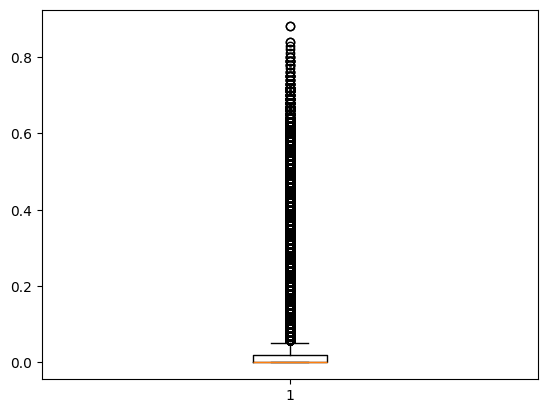

In [65]:
plt.boxplot(y_proba[:,1])

In [72]:
print('mean proba:', y_proba.mean(axis=0))
print('median proba:', np.median(y_proba, axis=0))

mean proba: [0.95280209 0.04719791]
median proba: [1. 0.]


As we can see on this boxplot, the distribution of the probabilities are not good at all. The're all condensed in low values (mean of 0.05) and should be recalibrated. 

We can check the aera under the roc curve to get a better idea of the actual model performance

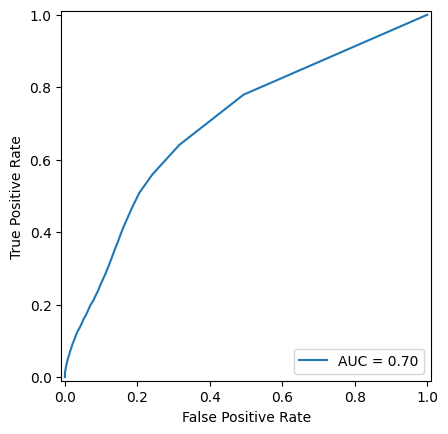

In [70]:
fpr, tpr, threshold = roc_curve(y_test, y_proba[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)
RocCurveDisplay(
    fpr=fpr,
    tpr=tpr,
    roc_auc=roc_auc
).plot()

Let's now check the evolution of f1-score depending on affection threeshold

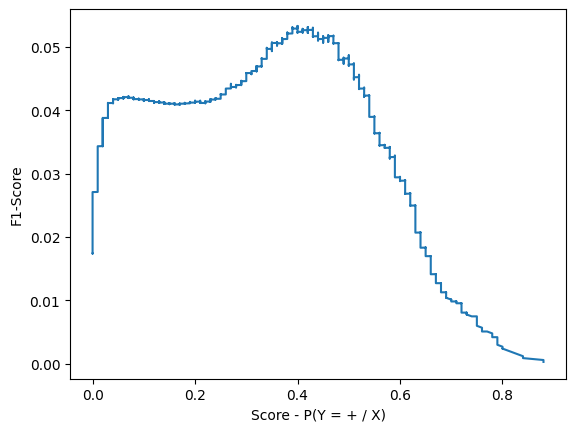

In [82]:
best_threeshold, best_score = score_threeshold(y_test, y_proba)

In [83]:
print('Best threeshold:', best_threeshold)
print('Best score:', best_score)

Best threeshold: 0.4
Best score: 0.053287260161862325


Calibrating the affectation threeshold only slightly improved the f1-score. The model score still is not the best we can get

## SVM